In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient
from kmeans import kMeans

from utils import measure_violations, generate_sim_matrix
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. Type of similarity matrix = binary, continuous
### 4. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [3]:
dataset_type = "COMPAS" # AdultCensus, Credit
similarity_matrix = "knn" # threshold
similarity_type = "binary" # continuous
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

PRINT_RESULT = True

In [4]:
similarity_params = dict()

if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    
    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"] = 20, 3

    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 10, 50, 0.1
    similarity_params["k"], similarity_params["threshold"]  = 20, 3

    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1

    similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
    similarity_params["k"], similarity_params["threshold"]  = 20, 7
    
    num_plot = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [5]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: COMPAS
Number of training data: 3700, Number of test data: 1850, Number of validation data: 617



# Obtains similarity matrix

In [6]:
w_train, edge_train, w_edge_train = generate_sim_matrix(x_train, similarity_matrix, similarity_params, similarity_type)
w_test, edge_test, w_edge_test = generate_sim_matrix(x_test, similarity_matrix, similarity_params, similarity_type)
w_val, edge_val, w_edge_val = generate_sim_matrix(x_val, similarity_matrix, similarity_params, similarity_type)

# Initial number of violations

In [7]:
num_actual_violations, num_actual_flips, runtime = dict(), dict(), dict()

init_violations = measure_violations(y_train, edge_train, w_edge_train)
print(f"Initial number of violations: {init_violations}")

Initial number of violations: 22321.0


# iFlipper on different target violation limits (m)

In [8]:
method = "iFlipper"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train, w_edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22321
Actual number of violations: 22321.0
Number of flips: 0
Runtime (sec): 0.00073
Target number of violations: 17856
Actual number of violations: 17855.0
Number of flips: 191
Runtime (sec): 5.26654
Target number of violations: 13392
Actual number of violations: 13378.0
Number of flips: 444
Runtime (sec): 7.19034
Target number of violations: 8928
Actual number of violations: 8919.0
Number of flips: 732
Runtime (sec): 5.79650
Target number of violations: 4464
Actual number of violations: 4459.0
Number of flips: 1067
Runtime (sec): 6.35408
Target number of violations: 2232
Actual number of violations: 2226.0
Number of flips: 1274
Runtime (sec): 5.94554
Target number of violations: 1116
Actual number of violations: 1113.0
Number of flips: 1430
Runtime (sec): 8.11892
Target number of violations: 223
Actual number of violations: 215.0
Number of flips: 1554
Runtime (sec): 5.97419
Target number of violations: 22
Actual number of violations: 20.0
Number of flips:

# Greedy algorithm
## Repeatedly flips label of nodes that reduce the number of violations the most

In [9]:
method = "Greedy"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)

    start = time.time()
    flipped_label = Greedy(y_train, m, w_train, edge_train, w_edge_train)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22321
Actual number of violations: 22321.0
Number of flips: 0
Runtime (sec): 0.00178
Target number of violations: 17856
Actual number of violations: 17844.0
Number of flips: 192
Runtime (sec): 15.31115
Target number of violations: 13392
Actual number of violations: 13390.0
Number of flips: 451
Runtime (sec): 35.73976
Target number of violations: 8928
Actual number of violations: 8922.0
Number of flips: 750
Runtime (sec): 59.38470
Target number of violations: 4464
Actual number of violations: 4459.0
Number of flips: 1106
Runtime (sec): 88.73102
Target number of violations: 2232
Actual number of violations: 2220.0
Number of flips: 1315
Runtime (sec): 109.29349
no more reduction
Target number of violations: 1116
Actual number of violations: 2197.0
Number of flips: 1324
Runtime (sec): 106.88998
no more reduction
Target number of violations: 223
Actual number of violations: 2197.0
Number of flips: 1324
Runtime (sec): 108.16949
no more reduction
Target number of 

# Gradient-based algorithm
## Solves an unconstrained optimization problem via gradient descent

In [10]:
method = "Gradient"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = Gradient(y_train, m, edge_train, w_edge_train, lam_high=60)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22321
Actual number of violations: 22321.0
Number of flips: 0
Runtime (sec): 38.67416
Target number of violations: 17856
Actual number of violations: 17347.0
Number of flips: 254
Runtime (sec): 35.45771
Target number of violations: 13392
Actual number of violations: 13364.0
Number of flips: 560
Runtime (sec): 34.89192
Target number of violations: 8928
Actual number of violations: 8417.0
Number of flips: 948
Runtime (sec): 36.27604
Target number of violations: 4464
Actual number of violations: 5985.0
Number of flips: 1855
Runtime (sec): 35.95787
Target number of violations: 2232
Actual number of violations: 5633.0
Number of flips: 1791
Runtime (sec): 35.65612
Target number of violations: 1116
Actual number of violations: 5666.0
Number of flips: 1857
Runtime (sec): 36.99154
Target number of violations: 223
Actual number of violations: 5334.0
Number of flips: 2032
Runtime (sec): 36.71577
Target number of violations: 22
Actual number of violations: 4453.0
Numbe

# kMeans-based algorithm
## Applies k-means clustering, and flips labels so that the examples within the same cluster have the same label

In [11]:
method = "kMeans"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = kMeans(x_train, y_train, m, edge_train, w_edge_train)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22321
Actual number of violations: 20927.0
Number of flips: 158
Runtime (sec): 18602.18257
Target number of violations: 17856
Actual number of violations: 17599.0
Number of flips: 530
Runtime (sec): 607.50475
Target number of violations: 13392
Actual number of violations: 13334.0
Number of flips: 876
Runtime (sec): 352.28356
Target number of violations: 8928
Actual number of violations: 8914.0
Number of flips: 1155
Runtime (sec): 177.50237
Target number of violations: 4464
Actual number of violations: 4409.0
Number of flips: 1350
Runtime (sec): 136.64775
Target number of violations: 2232
Actual number of violations: 2005.0
Number of flips: 1478
Runtime (sec): 105.93623
Target number of violations: 1116
Actual number of violations: 0.0
Number of flips: 1683
Runtime (sec): 88.08691
Target number of violations: 223
Actual number of violations: 0.0
Number of flips: 1683
Runtime (sec): 88.89554
Target number of violations: 22
Actual number of violations: 0.0
Num

# ILP Solver (using CPLEX)
## Solves the ILP problem exactly

In [12]:
method = "ILP"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = CPLEX_Solver(y_train, m, w_train, edge_train, ILP = True)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train, w_edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22321
Actual number of violations: 22321.0
Number of flips: 0
Runtime (sec): 73.35041
Target number of violations: 17856
Actual number of violations: 17855.0
Number of flips: 191
Runtime (sec): 116.02627
Target number of violations: 13392
Actual number of violations: 13392.0
Number of flips: 443
Runtime (sec): 164.14610
Target number of violations: 8928
Actual number of violations: 8922.0
Number of flips: 732
Runtime (sec): 137.31821
Target number of violations: 4464
Actual number of violations: 4463.0
Number of flips: 1067
Runtime (sec): 157.96415
Target number of violations: 2232
Actual number of violations: 2232.0
Number of flips: 1274
Runtime (sec): 450.71584
Target number of violations: 1116
Actual number of violations: 1116.0
Number of flips: 1408
Runtime (sec): 1329.86726
Target number of violations: 223
Actual number of violations: 223.0
Number of flips: 1540
Runtime (sec): 807.72444
Target number of violations: 22
Actual number of violations: 20.0


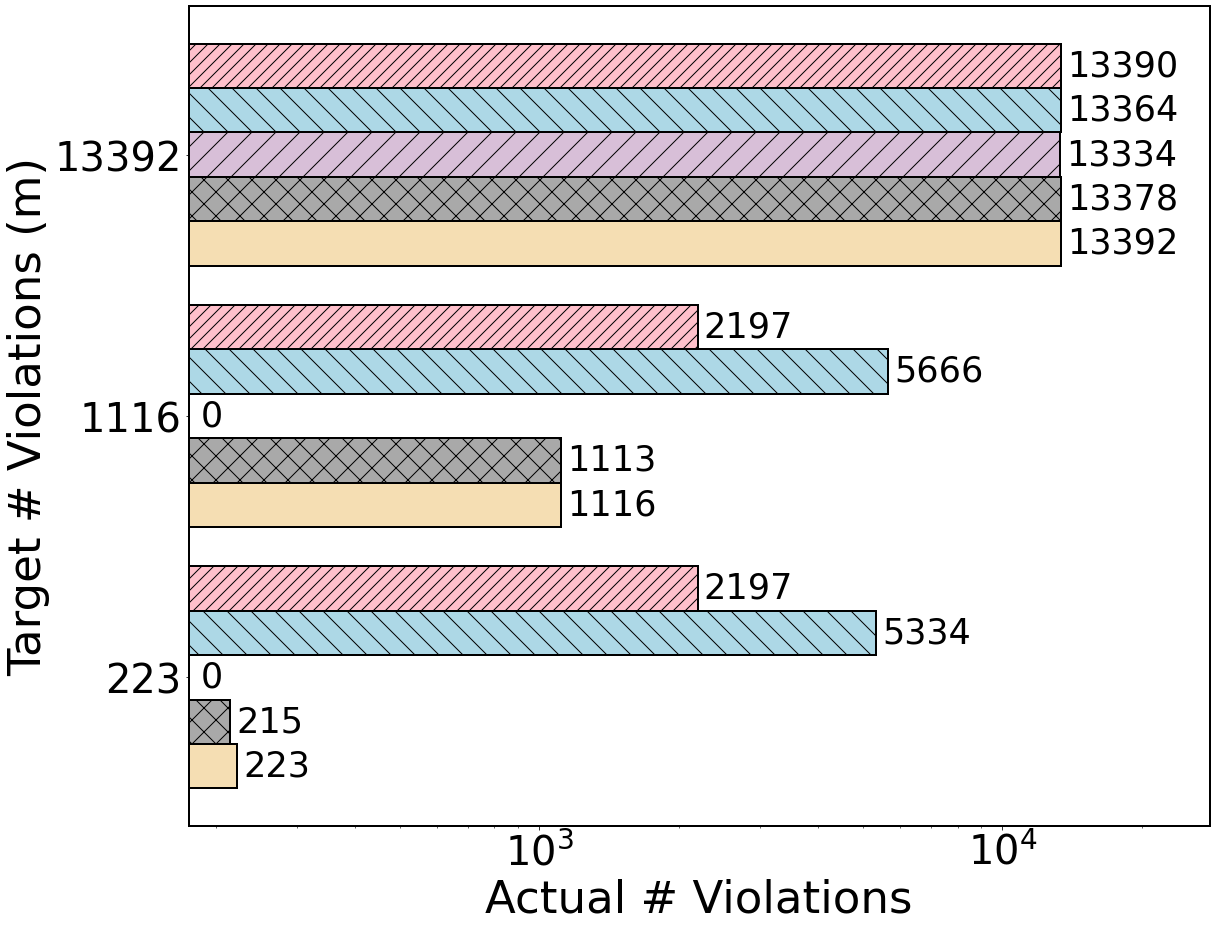

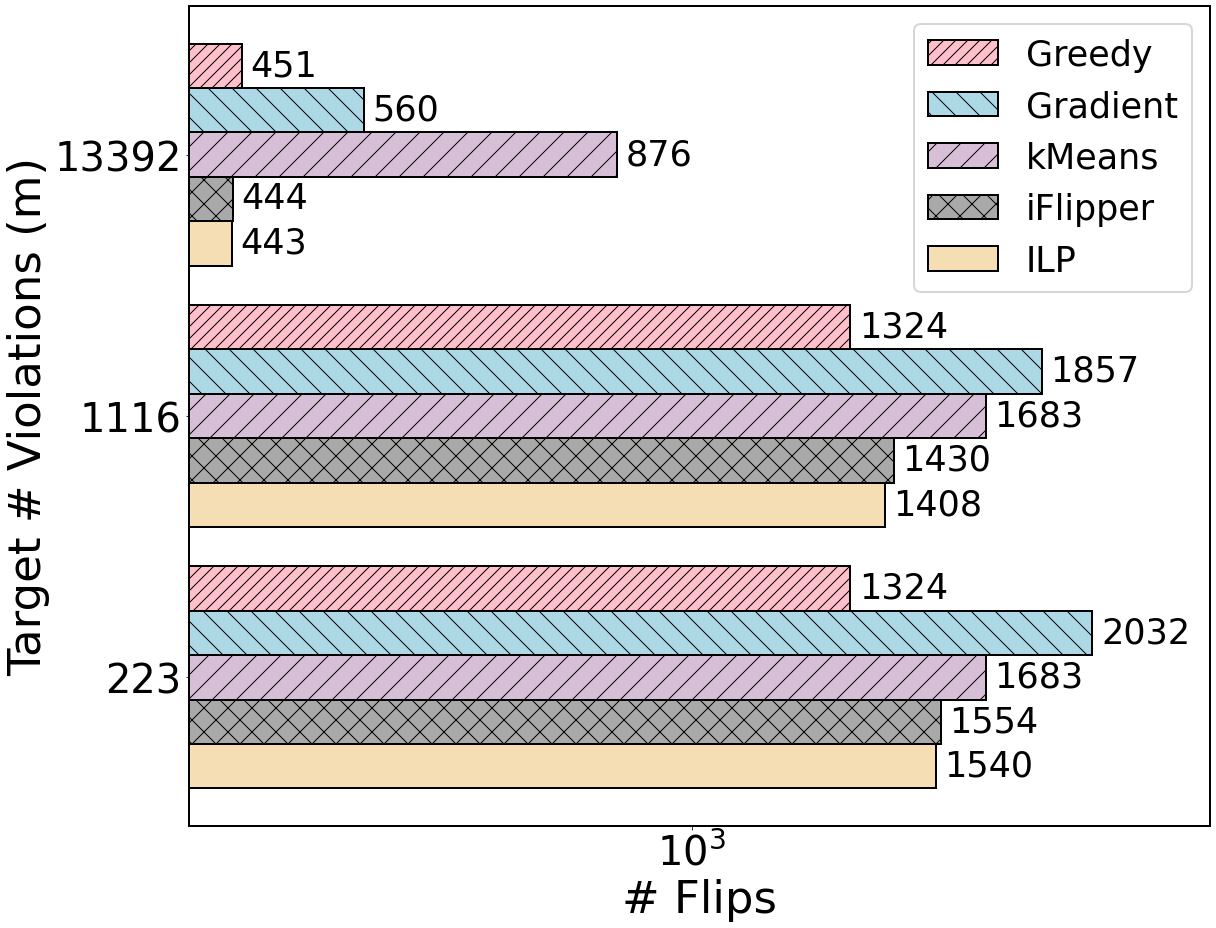

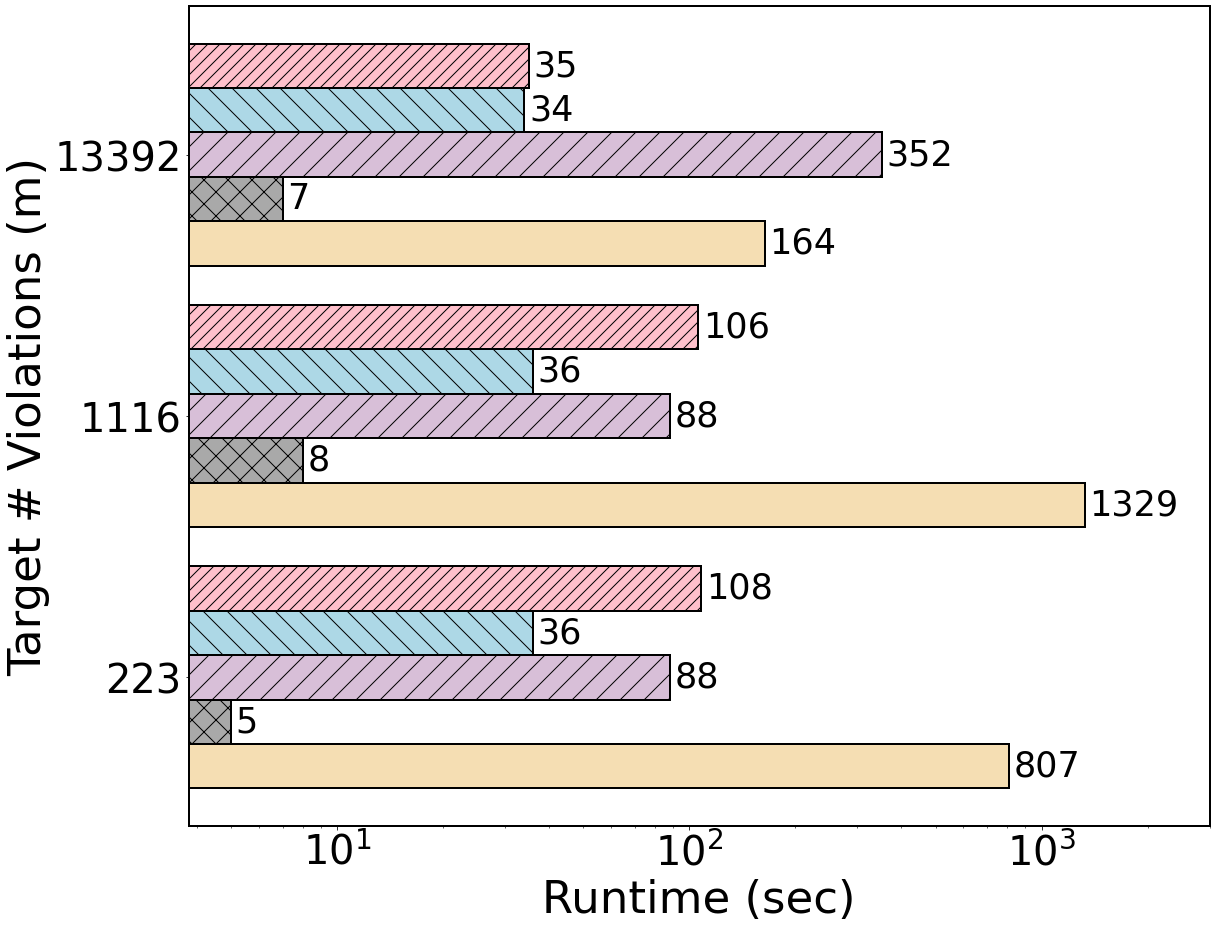

In [13]:
def plot_result(m_list, performance_arr, y_axis, num_digits):
    index = [2, 6, 7]
    labels = np.array(m_list)[index][::-1]

    plot1 = np.array(performance_arr["Greedy"])[index].astype(int)[::-1]
    plot2 = np.array(performance_arr["Gradient"])[index].astype(int)[::-1]
    plot3 = np.array(performance_arr["kMeans"])[index].astype(int)[::-1]
    plot4 = np.array(performance_arr["iFlipper"])[index].astype(int)[::-1]
    plot5 = np.array(performance_arr["ILP"])[index].astype(int)[::-1]

    x = np.arange(len(labels)) # the label locations
    width = 0.17  # the width of the bars

    plt.figure(1, figsize=(17,13))
    ax = plt.subplot()
    [x.set_linewidth(2) for x in ax.spines.values()]

    rects1 = ax.barh(x + width * 2, np.round(plot1, num_digits).astype(int), width, label="Greedy", color="pink", hatch='//',edgecolor="black", linewidth=2)
    rects2 = ax.barh(x + width * 1, np.round(plot2, num_digits).astype(int), width, label="Gradient", color="lightblue", hatch='\\',edgecolor="black", linewidth=2)
    rects3 = ax.barh(x - width * 0, np.round(plot3, num_digits).astype(int), width, label="kMeans", color="thistle", hatch='/',edgecolor="black", linewidth=2)
    rects4 = ax.barh(x - width * 1, np.round(plot4, num_digits).astype(int), width, label="iFlipper", color="darkgray", hatch='X',edgecolor="black", linewidth=2)
    rects5 = ax.barh(x - width * 2, np.round(plot5, num_digits).astype(int), width, label="ILP", color="wheat", edgecolor="black", linewidth=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.tick_params(labelsize=40)
    ax.set_xlabel(y_axis, fontsize=45)
    ax.set_ylabel("Target # Violations (m)", fontsize=45)

    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_xscale('log')

    max_val = 0
    if y_axis =="Actual # Violations":
        max_val = 180
        plt.xlim(0, 28000)
        max_ratio = 1.03
    elif y_axis =="# Flips":
        plt.minorticks_off()
        leg = ax.legend(prop={'size':35})
        plt.xlim(0, 2500)
        leg.get_frame().set_linewidth(2.0)
        max_ratio = 1.015
    else:
        plt.xlim(0, 3000)
        max_ratio = 1.03
        
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            ax.annotate('{}'.format(rect.get_width()),
                        xy=(max(rect.get_width(), max_val)*max_ratio, rect.get_y() + rect.get_height()*0.285),
                        fontsize=35)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)

    plt.tight_layout()
    plt.show()

m_list = []
for i in num_plot:
    m = int(init_violations * i)
    m_list.append(m)

plot_result(m_list, num_actual_violations, "Actual # Violations", 0)
plot_result(m_list, num_actual_flips, "# Flips", 0)
plot_result(m_list, runtime, "Runtime (sec)", 0)